# Classification of the alphabets from the American Sign Language

## _Find the best model_

![ASL](https://i.imgur.com/PKtsBNI.pnghttps://i.imgur.com/PKtsBNI.png)

# Table of contents

[<h3>1. Data preprocessing and visualization</h3>](#1)

[<h3>2. Load the Images with a generator and Data Augmentation</h3>](#2)

[<h3>3. Test 27 canned architectures with pre-trained weights</h3>](#3)

[<h3>4. Train the best architecture</h3>](#4)

[<h3>5. Examples of prediction</h3>](#5)

## Dataset

The data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes.

## Content

The training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING.
These 3 classes are very helpful in real-time applications, and classification.
The test data set contains a mere 29 images, to encourage the use of real-world test images.

The data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes.


# 1. Data preprocessing and visualization<a class="anchor" id="1"></a><a class="anchor" id="1"></a>


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Markdown, display


def printmd(string):
    # Print with Markdowns
    display(Markdown(string))


In [3]:
image_dir = Path("../Indian Sign Language/Indian/")

# Get filepaths and labels
filepaths = list(image_dir.glob(r"**/*.jpg"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [4]:
filepaths = pd.Series(filepaths, name="Filepath").astype(str)
labels = pd.Series(labels, name="Label")

# Concatenate filepaths and labels
df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
df = df.sample(frac=1).reset_index(drop=True)

print(f"Number of pictures in the dataset: {df.shape[0]}\n")
print(f"Number of different labels: {len(df.Label.unique())}\n")
print(f"Labels: {df.Label.unique()}")

# Show the result
df.head(5)


Number of pictures in the dataset: 42745

Number of different labels: 35

Labels: ['M' 'C' 'Y' 'H' 'K' '5' 'U' 'P' 'E' 'I' 'X' 'D' 'Z' 'V' '9' '1' 'N' '8'
 'W' '3' 'B' 'F' '4' 'G' '7' 'L' 'R' 'Q' '6' 'T' 'S' '2' 'O' 'A' 'J']


,Filepath,Label
0,..\Indian Sign Language\Indian\M\774.jpg,M
1,..\Indian Sign Language\Indian\C\118 copy.jpg,C
2,..\Indian Sign Language\Indian\Y\55.jpg,Y
3,..\Indian Sign Language\Indian\H\1034.jpg,H
4,..\Indian Sign Language\Indian\K\314.jpg,K


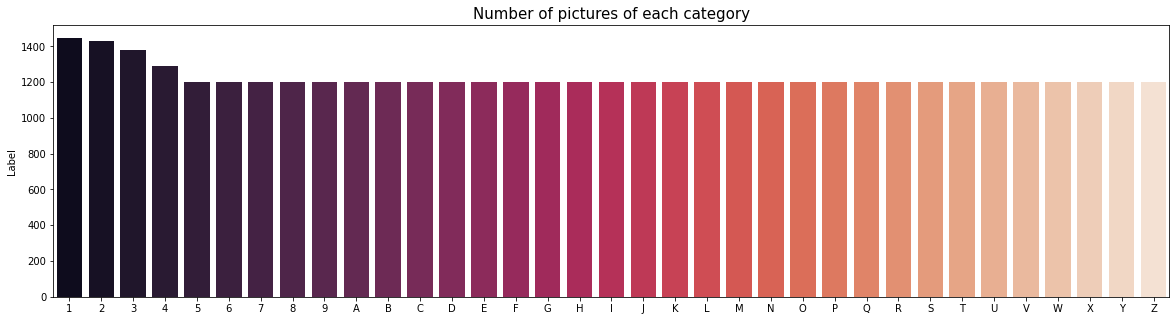

In [5]:
# Display the number of pictures of each category
vc = df["Label"].value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(x=sorted(vc.index), y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=15)
plt.show()


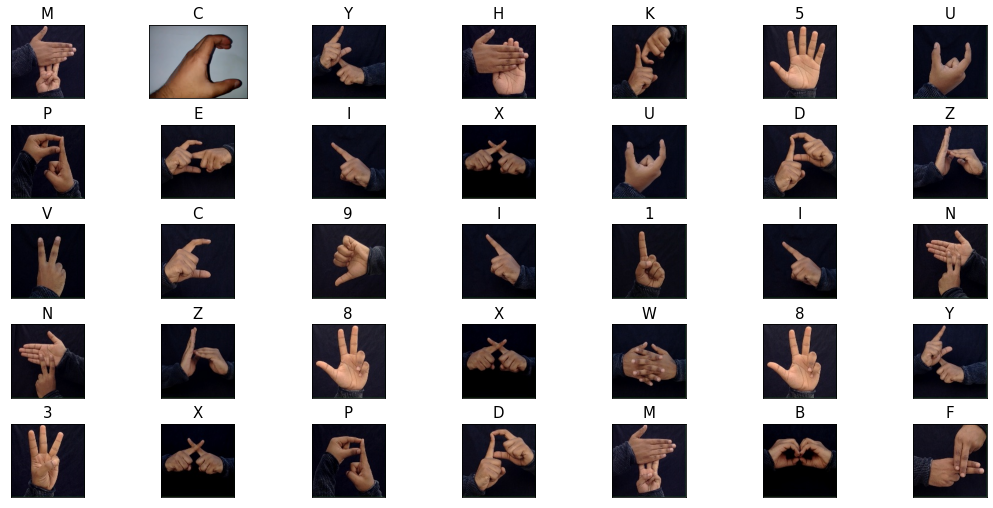

In [6]:
# Display some pictures of the dataset
fig, axes = plt.subplots(
    nrows=5, ncols=7, figsize=(15, 7), subplot_kw={"xticks": [], "yticks": []}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize=15)
plt.tight_layout(pad=0.5)
plt.show()


In [7]:
# Use 5% of the dataset for testing various models
# Split into training and test datasets
train_df, test_df = train_test_split(
    df.sample(frac=0.05), test_size=0.2, random_state=0
)


# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a><a class="anchor" id="1"></a>


In [8]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1,
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="Filepath",
        y_col="Label",
        target_size=(224, 224),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=0,
        subset="training",
        #         rotation_range=30, # Uncomment to use data augmentation
        #         zoom_range=0.15,
        #         width_shift_range=0.2,
        #         height_shift_range=0.2,
        #         shear_range=0.15,
        #         horizontal_flip=True,
        #         fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="Filepath",
        y_col="Label",
        target_size=(224, 224),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=0,
        subset="validation",
        #         rotation_range=30, # Uncomment to use data augmentation
        #         zoom_range=0.15,
        #         width_shift_range=0.2,
        #         height_shift_range=0.2,
        #         shear_range=0.15,
        #         horizontal_flip=True,
        #         fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col="Filepath",
        y_col="Label",
        target_size=(224, 224),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=32,
        shuffle=False,
    )

    return train_generator, test_generator, train_images, val_images, test_images


# 3. Test 27 canned architectures with pre-trained weights<a class="anchor" id="3"></a><a class="anchor" id="1"></a>

More info about the architectures under: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=enhttps://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en)


In [9]:
def get_model(model):
    # Load the pretained model
    kwargs = {
        "input_shape": (224, 224, 3),
        "include_top": False,
        "weights": "imagenet",
        "pooling": "avg",
    }

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation="relu")(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    outputs = tf.keras.layers.Dense(35, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


In [10]:
# Dictionary with the models
models = {
    "MobileNet": {"model": tf.keras.applications.MobileNetV2, "perf": 0},
    "InceptionV3": {"model": tf.keras.applications.InceptionV3, "perf": 0},
    "ResNet101V2": {"model": tf.keras.applications.ResNet101V2, "perf": 0},
    "ResNet152V2": {"model": tf.keras.applications.ResNet152V2, "perf": 0},
    "ResNet50V2": {"model": tf.keras.applications.ResNet50V2, "perf": 0},
}

# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()
print("\n")

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model["model"])
    models[name]["model"] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images, validation_data=val_images, epochs=1, verbose=1)

    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history["val_accuracy"]
    models[name]["val_acc"] = [round(v, 4) for v in val_acc]


Found 1539 validated image filenames belonging to 35 classes.
Found 170 validated image filenames belonging to 35 classes.
Found 428 validated image filenames belonging to 35 classes.


49/49 [==============================] - 59s 1s/step - loss: 1.1751 - accuracy: 0.7791 - val_loss: 0.0752 - val_accuracy: 1.0000
MobileNet            trained in 59.43 sec
49/49 [==============================] - 87s 2s/step - loss: 1.7617 - accuracy: 0.6205 - val_loss: 0.3036 - val_accuracy: 0.9824
InceptionV3          trained in 87.6 sec
49/49 [==============================] - 216s 4s/step - loss: 1.3391 - accuracy: 0.7433 - val_loss: 0.0825 - val_accuracy: 1.0000
ResNet101V2          trained in 216.59 sec
49/49 [==============================] - 323s 6s/step - loss: 1.2526 - accuracy: 0.7433 - val_loss: 0.0825 - val_accuracy: 0.9941
ResNet152V2          trained in 322.84 sec
49/49 [==============================] - 113s 2s/step - loss: 1.1837 - accuracy: 0.7700 - val_loss: 0.1069 - val_accuracy: 0.98

In [11]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([name, models[name]["val_acc"][-1], models[name]["perf"]])

df_results = pd.DataFrame(
    models_result, columns=["model", "val_accuracy", "Training time (sec)"]
)
df_results.sort_values(by="val_accuracy", ascending=False, inplace=True)
df_results.reset_index(inplace=True, drop=True)
df_results


,model,val_accuracy,Training time (sec)
0,MobileNet,1.0000,59.43
1,ResNet101V2,1.0000,216.59
2,ResNet152V2,0.9941,322.84
3,InceptionV3,0.9824,87.60
4,ResNet50V2,0.9824,112.83


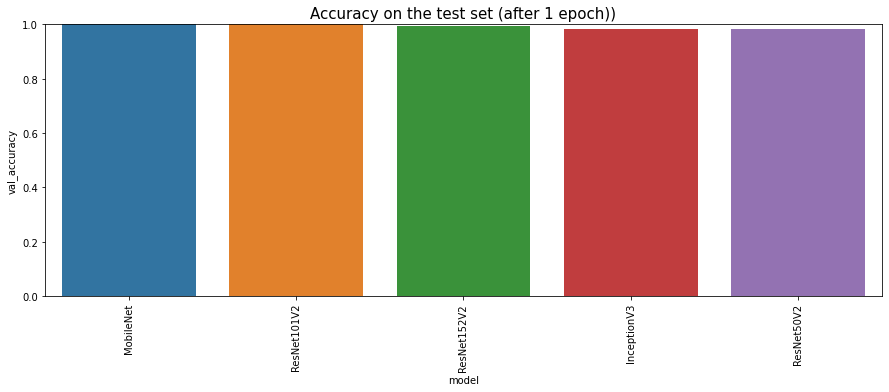

In [12]:
plt.figure(figsize=(15, 5))
sns.barplot(x="model", y="val_accuracy", data=df_results)
plt.title("Accuracy on the test set (after 1 epoch))", fontsize=15)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()


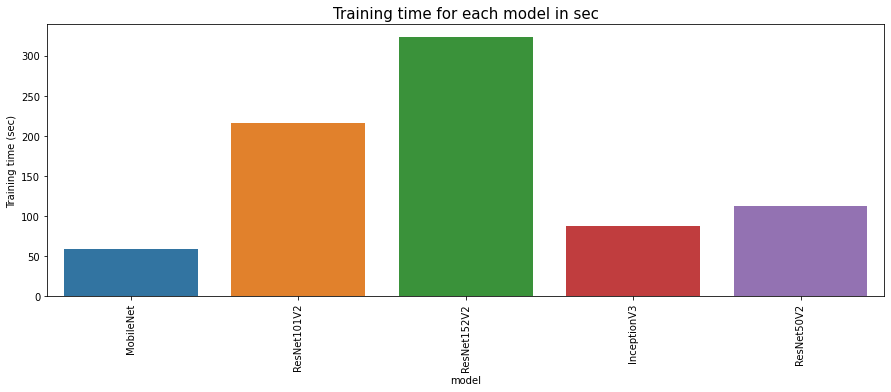

In [13]:
plt.figure(figsize=(15, 5))
sns.barplot(x="model", y="Training time (sec)", data=df_results)
plt.title("Training time for each model in sec", fontsize=15)
plt.xticks(rotation=90)
plt.show()


# 4. Train the architecture with the best result<a class="anchor" id="4"></a>

_With more than one epoch_


In [14]:
# Use the whole data which is split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()

# Get the model with the highest validation score
best_model = df_results.iloc[0]

# Create a new model
model = get_model(eval("tf.keras.applications." + best_model[0]))

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=1, restore_best_weights=True
        )
    ],
)


Found 34623 validated image filenames belonging to 35 classes.
Found 3847 validated image filenames belonging to 35 classes.
Found 4275 validated image filenames belonging to 35 classes.
Epoch 1/5
1082/1082 [==============================] - 1247s 1s/step - loss: 0.0621 - accuracy: 0.9898 - val_loss: 2.3182e-04 - val_accuracy: 1.0000
Epoch 2/5
1082/1082 [==============================] - 733s 678ms/step - loss: 1.0891e-04 - accuracy: 1.0000 - val_loss: 5.1070e-05 - val_accuracy: 1.0000
Epoch 3/5
1082/1082 [==============================] - 928s 857ms/step - loss: 3.0388e-05 - accuracy: 1.0000 - val_loss: 1.9933e-05 - val_accuracy: 1.0000
Epoch 4/5
1082/1082 [==============================] - 929s 858ms/step - loss: 1.2266e-05 - accuracy: 1.0000 - val_loss: 8.7584e-06 - val_accuracy: 1.0000
Epoch 5/5
1082/1082 [==============================] - 929s 859ms/step - loss: 5.6843e-06 - accuracy: 1.0000 - val_loss: 4.3117e-06 - val_accuracy: 1.0000


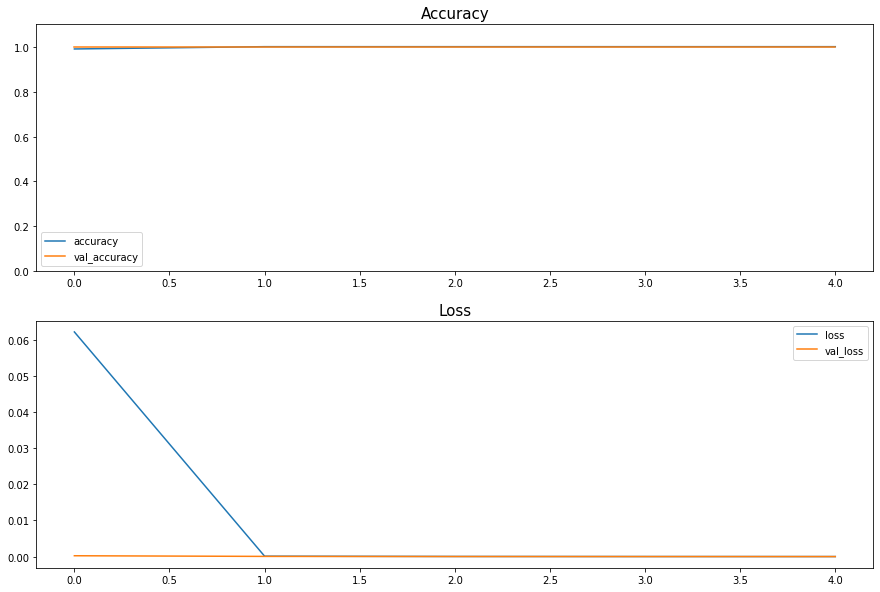

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize=15)
ax[0].set_ylim(0, 1.1)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize=15)
plt.show()


## Best Model: MobileNet with 100.00% accuracy on the test set

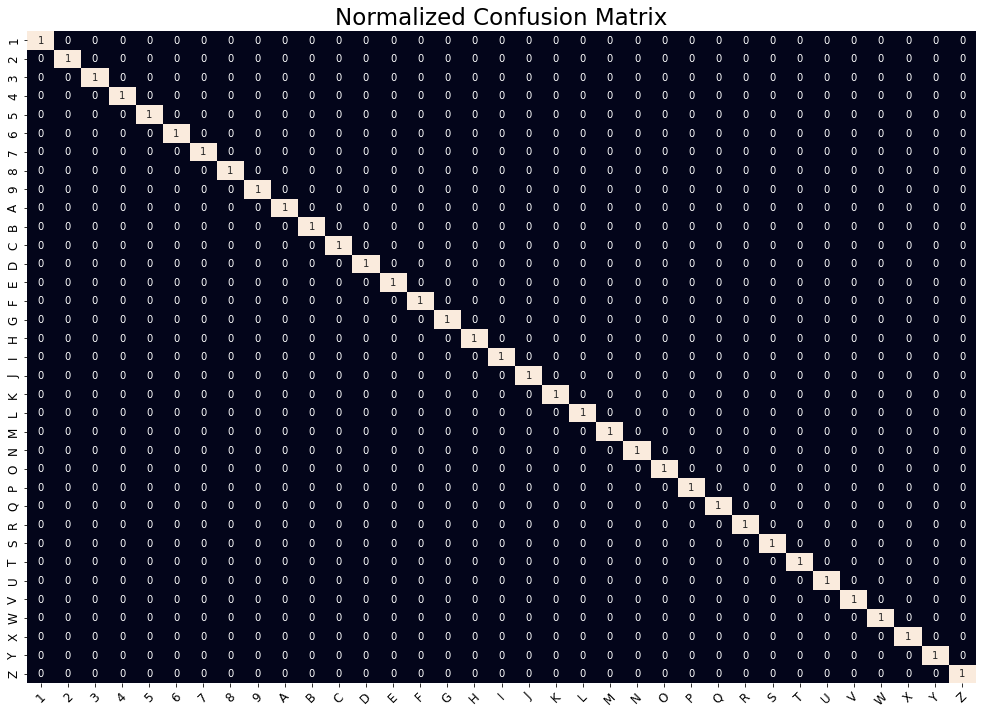

In [16]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = train_images.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)

# Display the results
printmd(f"## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set")

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize="true")
plt.figure(figsize=(17, 12))
sns.heatmap(
    cf_matrix,
    annot=True,
    xticklabels=sorted(set(y_test)),
    yticklabels=sorted(set(y_test)),
    cbar=False,
)
plt.title("Normalized Confusion Matrix", fontsize=23)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()


# 5. Examples of prediction<a class="anchor" id="5"></a><a class="anchor" id="1"></a>


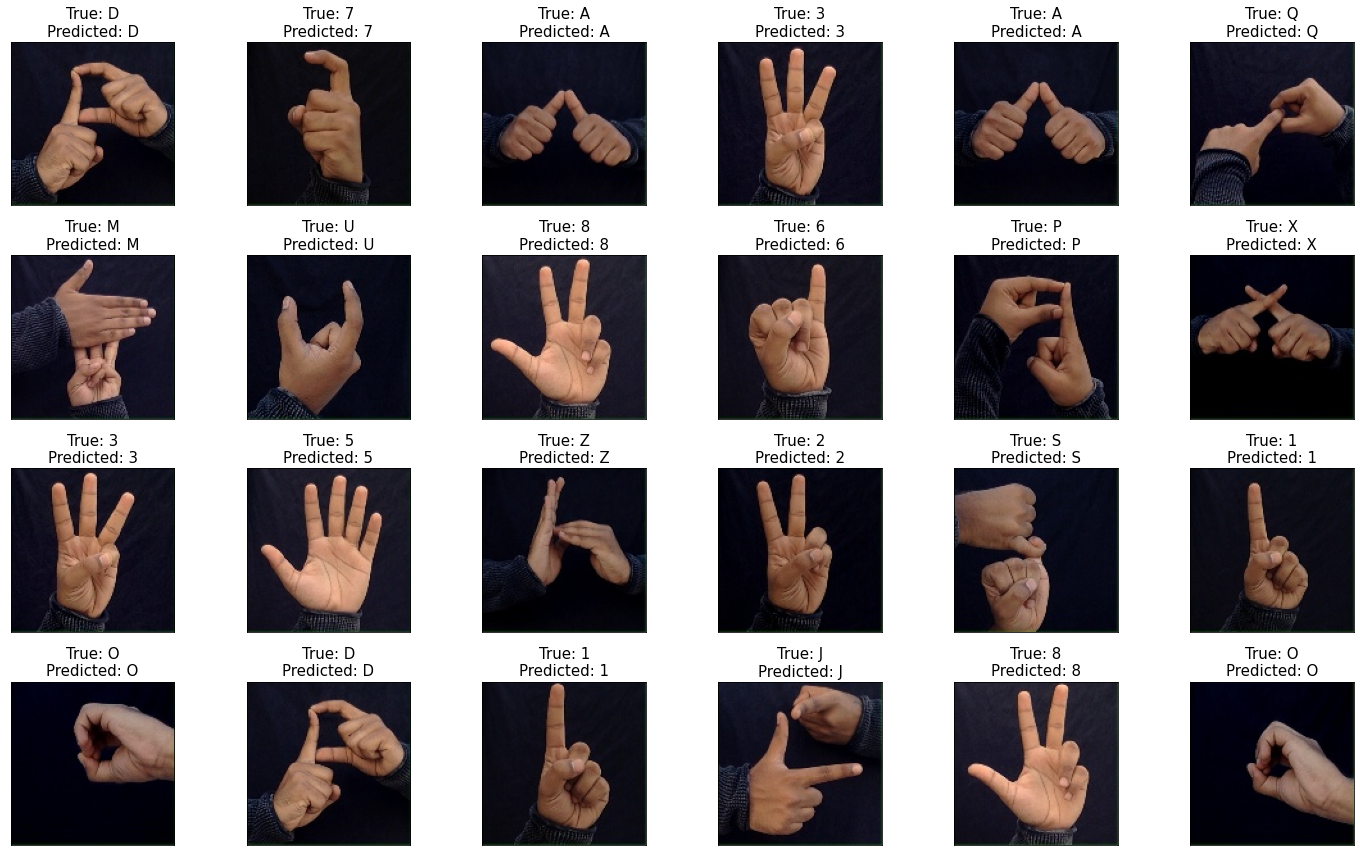

In [17]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(
    nrows=4, ncols=6, figsize=(20, 12), subplot_kw={"xticks": [], "yticks": []}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(
        f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}",
        fontsize=15,
    )
plt.tight_layout()
plt.show()
